In [1]:
import yt
from yt_experiments.tiled_grid import YTTiledArbitraryGrid, YTPyramid, YTOctPyramid
import matplotlib.pyplot as plt
import numpy as np
import zarr

ds = yt.load_sample("DeeplyNestedZoom")

yt : [INFO     ] 2024-08-23 12:13:23,853 Sample dataset found in '/Users/chavlin/data/yt_data/DeeplyNestedZoom/DD0025/data0025'
yt : [INFO     ] 2024-08-23 12:13:24,034 Parameters: current_time              = 14.1336338797
yt : [INFO     ] 2024-08-23 12:13:24,034 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-08-23 12:13:24,035 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-08-23 12:13:24,035 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-08-23 12:13:24,035 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-08-23 12:13:24,035 Parameters: current_redshift          = 14.092558914923
yt : [INFO     ] 2024-08-23 12:13:24,035 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2024-08-23 12:13:24,036 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2024-08-23 12:13:24,036 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-08-23 12:13:24,036 Parameters: hubb

## creating a single tiled grid in memory

Start with a small one that can fit in memory. Not super useful: could just use a single arbitrary grid, but good for demo:

In [2]:
tag = YTTiledArbitraryGrid(
    ds.domain_left_edge, ds.domain_right_edge, (400, 400, 400), 100, ds=ds
)
vals = tag.to_array(("gas", "density"))
print(vals.shape)

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1825/1825 [00:00<00:00, 21477.69it/s]
yt : [INFO     ] 2024-08-23 12:13:24,152 Gathering a field list (this may take a moment.)


(400, 400, 400)


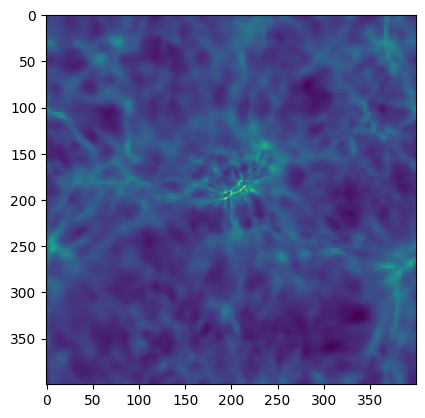

In [3]:
plt.imshow(np.log10(vals[:, :, 200]))

## A single tiled grid, larger-than memory on-disk zarr

In [10]:
tag = YTTiledArbitraryGrid(
    ds.domain_left_edge, ds.domain_right_edge, (2000, 2000, 2000), 100, ds=ds
)

In [11]:
zarr_store = zarr.group("tiled_grid.zarr")

In [12]:
dens = tag.to_zarr(
    ("gas", "density"),
    zarr_store,
)

In [13]:
dens.info

Name,/gas_density
Type,zarr.core.Array
Data type,float64
Shape,"(2000, 2000, 2000)"
Chunk shape,"(100, 100, 100)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,64000000000 (59.6G)
No. bytes stored,1397093571 (1.3G)


note directory layout

In [14]:
import os

os.listdir("tiled_grid.zarr/gas_density")[:10]

['15.17.8',
 '16.10.16',
 '5.8.10',
 '3.16.4',
 '8.10.11',
 '0.5.11',
 '10.11.17',
 '4.7.0',
 '5.13.7',
 '15.16.12']

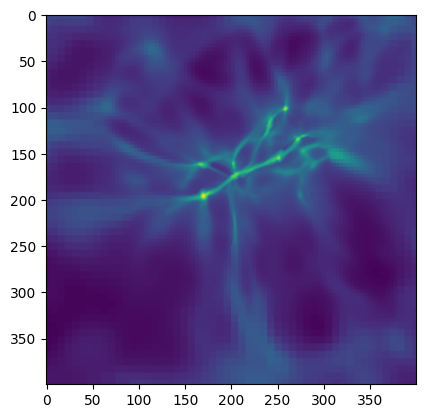

In [15]:
import matplotlib.pyplot as plt

plt.imshow(np.log10(dens[800:1200, 800:1200, 1000]))

## a pryamidal on-disk zarr

In [27]:
level_dims = [(res,) * 3 for res in range(1000, 0, -200)]
level_dims

[(1000, 1000, 1000),
 (800, 800, 800),
 (600, 600, 600),
 (400, 400, 400),
 (200, 200, 200)]

In [28]:
level_chunks = 200

In [29]:
pyr = YTPyramid(
    ds.domain_left_edge, ds.domain_right_edge, level_dims, level_chunks, ds=ds
)

Decomposing [1000 1000 1000] into 125 chunks for level 0
Decomposing [800 800 800] into 64 chunks for level 1
Decomposing [600 600 600] into 27 chunks for level 2
Decomposing [400 400 400] into 8 chunks for level 3
Decomposing [200 200 200] into 1 chunks for level 4


individual levels are comprised of `YTTiledArbitraryGrid` objects, accessible at:

In [30]:
pyr.levels[0]

In [31]:
pyr.levels[0].dims

array([1000, 1000, 1000])

can write to on-disk zarr with

In [32]:
zarr_store = zarr.group("deeply_nested_pyramid.zarr")

note we will downcast to float32 here by providing a dtype argument. This is because we'll later use this zarr to render in napari utilizing GPU rendering, at which point the values would be downcast anyway, so we might as well save a little space now. 

In [33]:
pyr.to_zarr(
    ("gas", "density"),
    zarr_store,
    zarr_name="density_log10",
    ops=[
        np.log10,
    ],
    dtype=np.float32,  #
)

writing level 0
writing level 1
writing level 2
writing level 3
writing level 4


In [34]:
zarr_store["density_log10"].info

Name,/density_log10
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,5
No. arrays,5
No. groups,0
Arrays,"0, 1, 2, 3, 4"


In [35]:
zarr_store["density_log10"]["0"].info

Name,/density_log10/0
Type,zarr.core.Array
Data type,float32
Shape,"(1000, 1000, 1000)"
Chunk shape,"(200, 200, 200)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,4000000000 (3.7G)
No. bytes stored,231287442 (220.6M)


In [36]:
zarr_store["density_log10"]["1"].info

Name,/density_log10/1
Type,zarr.core.Array
Data type,float32
Shape,"(800, 800, 800)"
Chunk shape,"(200, 200, 200)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,2048000000 (1.9G)
No. bytes stored,160995366 (153.5M)


In [37]:
zarr_store["density_log10"]["4"].info

Name,/density_log10/4
Type,zarr.core.Array
Data type,float32
Shape,"(200, 200, 200)"
Chunk shape,"(200, 200, 200)"
Order,C
Read-only,False
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,32000000 (30.5M)
No. bytes stored,19683104 (18.8M)


In [38]:
np.max(zarr_store["density_log10"]["3"]), np.min(zarr_store["density_log10"]["3"])

(-23.176695, -27.702736)

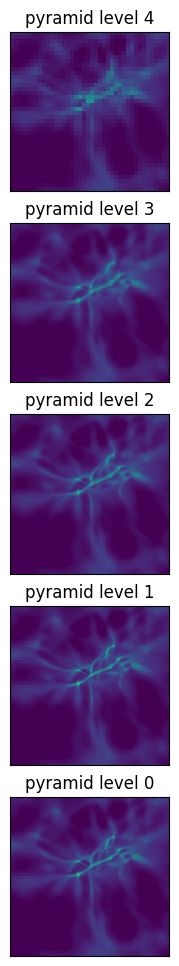

In [39]:
maxlevels = 5

f, axs = plt.subplots(ncols=1, nrows=maxlevels, figsize=(5, 12))
extent = (0, 1, 0, 1)

for ilevel in range(maxlevels - 1, -1, -1):
    vals_3d = zarr_store["density_log10"][str(ilevel)]
    shp = vals_3d.shape
    iplot = (maxlevels - 1) - ilevel
    im = axs[iplot].imshow(
        vals_3d[:, :, int(vals_3d.shape[-1] / 2)], extent=extent, vmin=-27, vmax=-23
    )
    axs[iplot].set_xlim([0.4, 0.6])
    axs[iplot].set_ylim([0.4, 0.6])
    axs[iplot].xaxis.set_visible(False)
    axs[iplot].yaxis.set_visible(False)
    axs[iplot].set_title(f"pyramid level {ilevel}")

### further optimizing for (interactive) visualization



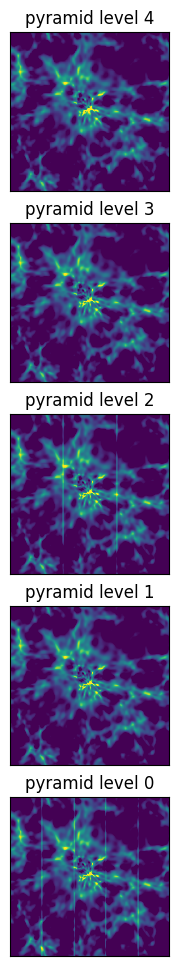

In [40]:
f, axs = plt.subplots(ncols=1, nrows=maxlevels, figsize=(5, 12))
extent = (0, 1, 0, 1)
for ilevel in range(maxlevels - 1, -1, -1):
    vals_3d = zarr_store["density_log10"][str(ilevel)]
    shp = vals_3d.shape
    iplot = (maxlevels - 1) - ilevel
    im = axs[iplot].imshow(
        vals_3d[:, int(vals_3d.shape[1] / 2), :], extent=extent, vmin=-27, vmax=-26
    )
    axs[iplot].xaxis.set_visible(False)
    axs[iplot].yaxis.set_visible(False)
    axs[iplot].set_title(f"pyramid level {ilevel}")

## visualizing 3D pyramid

main napari will lag... should try https://github.com/napari/napari/pull/6043 branch

In [8]:
import napari
import zarr

In [9]:
zarr_store = zarr.group("deeply_nested_pyramid.zarr")
zarr_store["density_log10"].info

Name,/density_log10
Type,zarr.hierarchy.Group
Read-only,False
Store type,zarr.storage.DirectoryStore
No. members,5
No. arrays,5
No. groups,0
Arrays,"0, 1, 2, 3, 4"


In [14]:
density = [lev for _, lev in zarr_store["density_log10"].arrays()]
density = density[1:]  # avoid lag

In [15]:
v = napari.Viewer()

In [16]:
v.add_image(density, contrast_limits=(-28, -23), colormap="viridis")

<Image layer 'density' at 0x3161a13c0>

In [17]:
v.camera.zoom = 0.1

In [7]:
v.close()